In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import os
import scipy.misc as sm
import skimage
from  skimage.feature import canny
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import convolve
from tensorflow.keras.layers import Conv2D

from scipy import misc
import numpy as np

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

**Diatas saya mendefine function gaussian kernel yang berfungi untuk membuat kernel/filter gaussian yang berguna untuk membuat gambar lebih blur atau berbayang secara merata caranya sendiri pun adalah dengan mencari/menjumlah dan mencari nilai rata - rata dari intensitas setiap pixelnya untuk diberikan nilai kepada kernelnya**

In [ ]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

**Disini saya mendefine function sobel filter yang berguna untuk proses gradient calculation nantinya, saya memilih sobel filter karena sobel cukup efektif dalam mencari edge atau garis pada tahap pertama karena memiliki 2 sumbu gradient yaitu sobel x dan sobel y**

In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    #pi_4 = np.pi / 4
    #pi_2 = np.pi / 2
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                #theta = D[i,j] #* 180 / np.pi #angle in degrees
                #theta_mod = theta % np.pi
                q = 255
                r = 255
                #alpha = None
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                

            except IndexError as e:
                pass
    
    return Z

**Disini saya mendefine function non max suppresion yang berguna untuk mempertajam hasil dari gradient calculation yang nantinya saya akan jelaskan lebih dalam**

In [ ]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


**Disini saya mendefine function threshold yang berguna untuk memberikan nilai treshold pada intensity suatu gambar yang akan berguna nantinya untuk mempertajam hasil edgenya dan membedakan mana yang edge tajam dan tidak untuk function tresholdnya sendiri saya menggunakna double threshold dimana terdapat lowthreshold dan hightreshold**

In [ ]:
def hysteresis(img, weak, strong=255):
    
    M, N = img.shape  
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    
    return img

**Disini saya membuat function hysteresis yang berguna untuk "menghaluskan" hasil gambar edge detection yang sudah dipertajam oleh treshold sehingga gambar edge semakin dapat dibedakan dan semakin jelas**

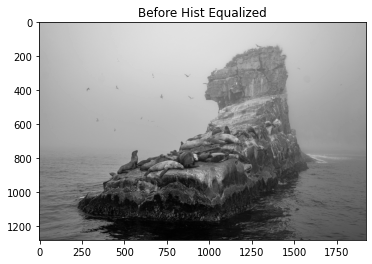

In [ ]:
img = mpimg.imread('Seals.jpg')
img = skimage.color.rgb2gray(img)
plt.title("Before Hist Equalized")
plt.imshow(img, cmap='gray')

**Disini saya menload atau meread image yang saya ambil dari internet, untuk imagenya sendiri saya menggunakan image dengan kualitas hd dengan ratio dimensi pixel 1920 x 1280 dan saya convert gambarnya ke grayscale**

In [ ]:
img_filtered = convolve(img, gaussian_kernel(5, sigma=1.4))

**Lalu karena gambarnya cukup HD sehingga gambarnya pasti memiliki noise yang dapat menggangu proses identifikasi edge karena semakin tajam suatu gambar maka makin banyak noise yang akan ditangkap oleh karena itu kita perlu melakukan proses smoothing atau penghalusan dengan melakukan filtering dengan gaussiankernel function yang sudah saya buat.**

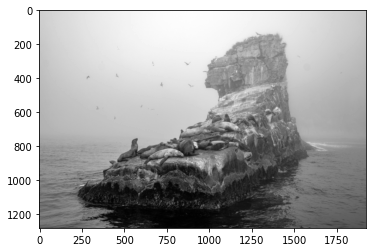

In [ ]:
plt.imshow(img_filtered, cmap='gray')

**Berikut adalah hasil gambar setelah diberikan gaussian kernel dimana gambar yang dihasilkan akan menjadi blur namun menghilangkan noise yang ada pada gambar sehingga lebih mudah untuk diproses oleh komputer**

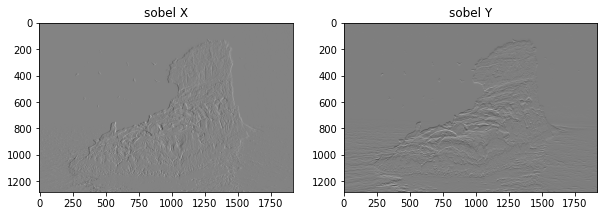

In [ ]:
import cv2
grad, theta = sobel_filters(img_filtered)
sobel_x = cv2.Sobel(img_filtered, cv2.CV_64F, 1, 0, 3)
sobel_y = cv2.Sobel(img_filtered, cv2.CV_64F, 0, 1, 3)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("sobel X")
plt.imshow(sobel_x, cmap='gray')

plt.subplot(1, 2, 2) 
plt.title("sobel Y")
plt.imshow(sobel_y, cmap='gray')

plt.show()

**Lalu untuk mencari edge terlebih dahulu saya menggunakan sobel untuk mendapatkan edge dari sumbu x dan y dan dapat kita lihat bahwa garis yang dihasilkan oleh sobel pada edge sudah cukup baik namun kurang tebal atau kurang tajam  dan masih sedikit berbayang  serta garis yang dihasilkna masih terlalu tebal sehingga kita perlu melakukan langkah selanjutnya untuk mempertajam**

In [ ]:
img_nms = non_max_suppression(grad, theta)

**dan pada langkah ini kita memproses hasil gambar sebelumnya ke function non max suppresion dimana kita akan mencoba untuk mempertipis garis yang dihasilkan oleh sobel sehingga hasil akan lebih akurat cara kerja dari function ini adalah mengecek pixel pada garis - garis yang menandakan edge dan mengconvert pixel yang mempunyai intensitas tinggi akan langsung di convert menjadi intesitas max atau warna putih sehingga pixel pada garis akan semakin ramping dan garis akan lebih tipis karena tujuan dari non max suppression ini adalah menggabungkan banyak garis yang overlapping menjadi 1 garis saja**

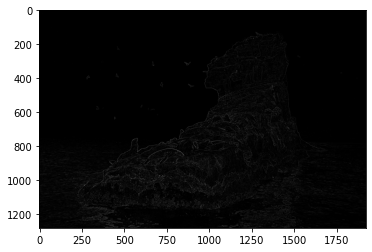

In [ ]:
plt.imshow(img_nms, cmap='gray')

**Berikut adalah hasil setelah non max suppresion di implementasikan dapat dilihat bahwa garis sudah lebih akurat dan tipis namun masih cukup sulit untuk dilihat karena dapat dilihat bahwa masih terdapat banyak sekali variasi ketebalan pada garis garis tersebut oleh karena itu kita perlu melakukan langkah selanjutnya.**

In [ ]:
img_thresh, weak, strong = threshold(img_nms, lowThresholdRatio=0.05, highThresholdRatio=0.19)

**Kita akan mengubah variasi garis tersebut menjadi 2 variasi dimana edge yang tebal atau sangat terlihat akan masuk ke high treshold atau menjadi sangat tebal dan edge yang kurang terlihat akan masuk ke lowthreshold atau menjadi garis tipis kita akan menggunakan ratio low dan high threshold yaitu 0.05 dan 0.19**

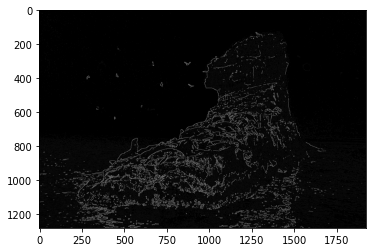

In [ ]:
plt.imshow(img_thresh, cmap='gray')

**sudah dapat dilihat bahwa garis edge sudah semakin jelas terlihat namun masih terdapat beberapa detail yang masih kurang dideteksi secara jelas karena edgenya kurang jelas pada gambar contohnya pada bagian kanan atas batu oleh karena itu kita membutuhkan hysteresis**

In [ ]:
img_final = hysteresis(img_thresh, weak, strong=strong)

**Hysteresis adalah proses dimana algoritma akan mengecek pixel pixel dalam suatu garis dan membandingkanya dengan tetangga dari pixel tersebut jika pixel tersebut memiliki 1 tetangga dengan tingkat intensitas yang lebih tinggi darinya(lebih putih) maka pixel tersebut akan dikonvert menjadi intesitas tetangganya yang tinggi (menjadi pixel putih), dan berlaku sebaliknya**

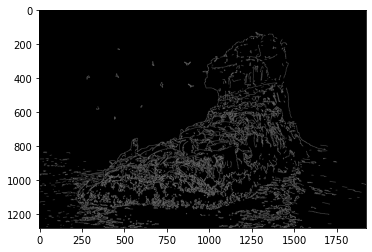

In [ ]:
plt.imshow(img_final, cmap='gray')

**Dan bisa kita lihat berikut adalah hasil setelah diberikan hysteresis dan kita dapat lihat bahwa garis pada bagian atas batu kanan sudah jelas**